In [306]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submission-file/Submission_template_UHI2025-v2.csv
/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv


In [307]:
pip install overpy 

Note: you may need to restart the kernel to use updated packages.


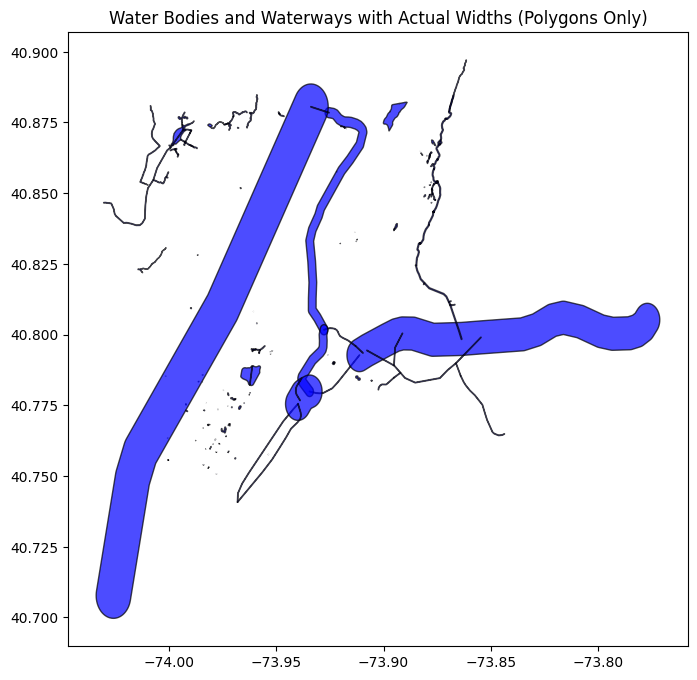

In [308]:
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon

# Define bounding box (min lat, min lon, max lat, max lon)
bbox = (40.75, -74.01, 40.88, -73.86)

# Overpass API query to fetch natural water bodies and waterways (excluding coastlines)
query = f"""
[out:json];
(
  way["natural"="water"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
  relation["natural"="water"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
  way["waterway"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
);
out geom;
"""

# Request data from Overpass API
url = "http://overpass-api.de/api/interpreter"
response = requests.get(url, params={"data": query})
data = response.json()

# Parse features
water_polygons = []
waterway_polygons = []

# Define river widths (in meters) for the known rivers in the region
RIVER_WIDTHS = {
    "hudson river": 900,  # 0.6 miles
    "harlem river": 200,  # Average of 400 to 1,200 feet
    "east river": 650,    # Average of 600 to 4,000 feet
    "bronx river": 20,     # Average of 6 to 12 meters
}

for element in data["elements"]:
    if "geometry" in element:
        coords = [(point["lon"], point["lat"]) for point in element["geometry"]]
        
        # Water bodies (lakes, reservoirs)
        if "natural" in element.get("tags", {}) and element["tags"]["natural"] == "water":
            water_polygons.append(Polygon(coords))
        
        # Waterways (rivers, streams, canals)
        elif "waterway" in element.get("tags", {}):
            waterway_name = element["tags"].get("name", "").lower()
            width_meters = RIVER_WIDTHS.get(waterway_name, 10)  # Default to 10 meters if not found
            
            buffer_size = width_meters / 111320  # Convert meters to degrees
            waterway_polygons.append(Polygon(LineString(coords).buffer(buffer_size).exterior.coords))

# Convert to GeoDataFrames (only polygons)
water_gdf = gpd.GeoDataFrame(geometry=water_polygons, crs="EPSG:4326")
waterway_gdf = gpd.GeoDataFrame(geometry=waterway_polygons, crs="EPSG:4326")

# Merge both datasets for unified plotting (only polygons)
gdf = gpd.GeoDataFrame(
    geometry=water_gdf.geometry.tolist() + waterway_gdf.geometry.tolist(), crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, color="blue", alpha=0.7, edgecolor="black")
ax.set_title("Water Bodies and Waterways with Actual Widths (Polygons Only)")
plt.show()


In [309]:
gdf

,geometry
0,"POLYGON ((-73.96124 40.78883, -73.96127 40.788..."
1,"POLYGON ((-73.99878 40.86677, -73.99904 40.866..."
2,"POLYGON ((-73.97375 40.76569, -73.97374 40.765..."
3,"POLYGON ((-73.96726 40.77373, -73.96718 40.773..."
4,"POLYGON ((-73.96171 40.79491, -73.96170 40.794..."
...,...
261,"POLYGON ((-73.91819 40.87307, -73.91819 40.873..."
262,"POLYGON ((-73.86626 40.78986, -73.86626 40.789..."
263,"POLYGON ((-73.96129 40.79419, -73.96129 40.794..."
264,"POLYGON ((-73.96127 40.79432, -73.96126 40.794..."


In [310]:
train_df = pd.read_csv("/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv")

In [311]:
train_df

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245


In [312]:
from shapely.geometry import Point

# Convert train_df into a GeoDataFrame with geometry as points
gdf_train = gpd.GeoDataFrame(train_df, 
                             geometry=[Point(lon, lat) for lon, lat in zip(train_df['Longitude'], train_df['Latitude'])], 
                             crs="EPSG:4326")

gdf_water = gdf

# Reproject train data and water polygons to EPSG:3395 (meters) for accurate distance-based calculations
gdf_train = gdf_train.to_crs(epsg=3395)
gdf_water = gdf_water.to_crs(epsg=3395)

# Create a 200m buffer around each train point
gdf_train['buffer'] = gdf_train.geometry.buffer(750)

# Function to calculate the area of intersection between the buffer and water polygons
def intersection_area_in_buffer(buffer_geom, water_gdf):
    # Find the intersection of the buffer with the water geometries
    intersection = water_gdf.geometry.intersection(buffer_geom)
    
    # Calculate the area of each intersected water polygon and sum it
    area = intersection.area.sum()  # Sum areas of all intersecting polygons
    return area

# Apply the function to compute the area of intersection inside the buffer
gdf_train['water'] = gdf_train['buffer'].apply(
    lambda buffer_geom: intersection_area_in_buffer(buffer_geom, gdf_water)
)

# Convert back to a regular DataFrame if needed
train_df['water'] = gdf_train['water']

# Check results
print(train_df[['Longitude', 'Latitude', 'water']].head())

   Longitude   Latitude  water
0 -73.909167  40.813107    0.0
1 -73.909187  40.813045    0.0
2 -73.909215  40.812978    0.0
3 -73.909242  40.812908    0.0
4 -73.909257  40.812845    0.0


In [313]:
train_df

,Longitude,Latitude,datetime,UHI Index,water
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.000000
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.000000
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.000000
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.000000
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.000000
...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,245597.036636
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,247432.375481
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,250909.526972
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,252775.520282


In [314]:
train_df['water'].describe()

count    1.122900e+04
mean     1.440976e+05
std      2.422051e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.257575e+04
75%      1.987282e+05
max      1.160696e+06
Name: water, dtype: float64

In [315]:
train_df.to_csv('train_df_with_water.csv', index=False)

In [316]:
valid_df = pd.read_csv("/kaggle/input/submission-file/Submission_template_UHI2025-v2.csv")

In [317]:
valid_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN
...,...,...,...
1035,-73.919388,40.813803,NaN
1036,-73.931033,40.833178,NaN
1037,-73.934647,40.854542,NaN
1038,-73.917223,40.815413,NaN


In [318]:
# Convert valid_df into a GeoDataFrame with geometry as points
valid_gdf = gpd.GeoDataFrame(valid_df, 
                             geometry=[Point(lon, lat) for lon, lat in zip(valid_df['Longitude'], valid_df['Latitude'])], 
                             crs="EPSG:4326")

# Reproject valid_gdf and water polygons to EPSG:3395 (meters) for accurate distance-based calculations
valid_gdf = valid_gdf.to_crs(epsg=3395)
gdf_water = gdf_water.to_crs(epsg=3395)

# Create a 200m buffer around each valid point
valid_gdf['buffer'] = valid_gdf.geometry.buffer(750)

# Function to calculate the area of intersection between the buffer and water polygons
def intersection_area_in_buffer(buffer_geom, water_gdf):
    # Find the intersection of the buffer with the water geometries
    intersection = water_gdf.geometry.intersection(buffer_geom)
    
    # Calculate the area of each intersected water polygon and sum it
    area = intersection.area.sum()  # Sum areas of all intersecting polygons
    return area

# Apply the function to compute the area of intersection inside the buffer
valid_gdf['water'] = valid_gdf['buffer'].apply(
    lambda buffer_geom: intersection_area_in_buffer(buffer_geom, gdf_water)
)

# Convert back to a regular DataFrame if needed
valid_df['water'] = valid_gdf['water']

# Check results
print(valid_df.head())

   Longitude   Latitude  UHI Index          water
0 -73.971665  40.788763        NaN   32491.027812
1 -73.971928  40.788875        NaN   18151.225888
2 -73.967080  40.789080        NaN  313644.561414
3 -73.972550  40.789082        NaN       0.000000
4 -73.969697  40.787953        NaN  175156.542666


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [319]:
valid_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Longitude,Latitude,UHI Index,water
0,-73.971665,40.788763,NaN,32491.027812
1,-73.971928,40.788875,NaN,18151.225888
2,-73.967080,40.789080,NaN,313644.561414
3,-73.972550,40.789082,NaN,0.000000
4,-73.969697,40.787953,NaN,175156.542666
...,...,...,...,...
1035,-73.919388,40.813803,NaN,0.000000
1036,-73.931033,40.833178,NaN,569722.940080
1037,-73.934647,40.854542,NaN,174026.173971
1038,-73.917223,40.815413,NaN,0.000000


In [320]:
valid_df['water'].describe()

count    1.040000e+03
mean     1.520436e+05
std      2.474156e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.594299e+04
75%      2.304905e+05
max      1.148900e+06
Name: water, dtype: float64

In [321]:
valid_df.to_csv('valid_df_with_water.csv', index=False)